# Минимальная нейросеть “с нуля” в PyTorch
**Тема:** строим свою самую простую нейронную сеть (MLP) для бинарной классификации + обучение + оценка + сохранение.  

## Что сделаем за урок
1) создадим датасет (2D “луны”)  
2) подготовим данные и DataLoader  
3) напишем **свой класс модели** `nn.Module`  
4) напишем **обучающий цикл** (train loop) без магии  
5) добавим оценку (accuracy + confusion matrix) и порог  
6) сохраним модель и загрузим обратно  
7) сделаем 10 заданий на закрепление

> Почему `make_moons`? Там нужна нелинейная граница — видно, зачем нужен hidden-layer.


In [3]:
# Если torch не установлен: в Colab обычно уже есть.
# В обычном ноутбуке: pip install torch (может требовать отдельной установки под вашу ОС)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("torch:", torch.__version__)
print("device:", device)

torch: 2.9.0+cpu
device: cpu


# 1) Данные (классификация)

У нас бинарная классификация:
- **X**: два признака (x1, x2)
- **y**: 0 или 1 (класс)

Делим на train/test, затем делаем DataLoader (батчи).


train: (900, 2) (900, 1)
test : (300, 2) (300, 1)


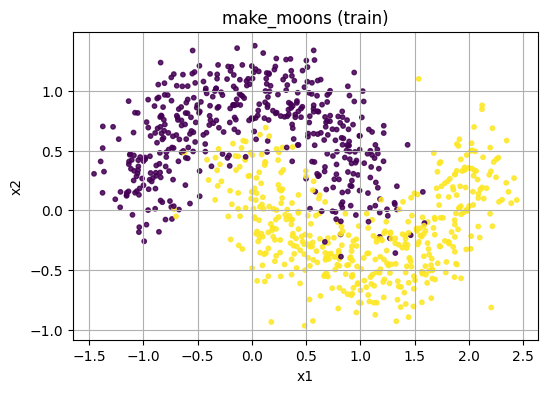

In [4]:
# Генерируем данные
X, y = make_moons(n_samples=1200, noise=0.22, random_state=42)

# Приводим типы: torch любит float32
X = X.astype(np.float32)
y = y.astype(np.float32).reshape(-1, 1)  # (n,1) float для BCEWithLogitsLoss

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("train:", X_train.shape, y_train.shape)
print("test :", X_test.shape, y_test.shape)

# Визуализация
plt.figure(figsize=(6,4))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.reshape(-1), s=10, alpha=0.85)
plt.title("make_moons (train)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.grid(True)
plt.show()

## 1.1) TensorDataset и DataLoader

- `TensorDataset(X, y)` хранит пары (features, target)
- `DataLoader` даёт батчи и перемешивание

Обучение обычно идёт **батчами**, а не всем датасетом сразу.


In [5]:
# numpy -> torch
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

xb, yb = next(iter(train_loader))
print("batch X:", xb.shape, xb.dtype)
print("batch y:", yb.shape, yb.dtype)

batch X: torch.Size([64, 2]) torch.float32
batch y: torch.Size([64, 1]) torch.float32


# 2) Модель: “самая минимальная нейросеть”

**Архитектура**
- Linear(2 → 16)
- ReLU
- Linear(16 → 1) → **логит**

Почему логит?
- Это число до сигмоиды.
- Мы используем `BCEWithLogitsLoss`, которая **внутри** применит sigmoid стабильно.

Итого: `forward` возвращает logits формы (batch, 1).


In [7]:
class TinyNet(nn.Module):
    def __init__(self, n_in=2, n_hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        # x: (batch, 2)
        x = self.fc1(x)        # (batch, hidden)
        x = F.relu(x)          # нелинейность
        logits = self.fc2(x)   # (batch, 1)
        return logits

model = TinyNet(n_in=2, n_hidden=16).to(device)
print(model)
print("params:", sum(p.numel() for p in model.parameters()))

TinyNet(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)
params: 65


# 3) Loss и Optimizer

Для бинарной классификации:
- **Loss:** `nn.BCEWithLogitsLoss()` принимает (logits, y_true_float)
- **Optimizer:** `Adam` или `SGD`

Важно:
- перед backward делаем `optimizer.zero_grad()`


In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("criterion:", type(criterion).__name__)
print("optimizer:", type(optimizer).__name__)

criterion: BCEWithLogitsLoss
optimizer: Adam


# 4) Обучение: train loop “вручную”

Шаблон (золотой стандарт):

1) `logits = model(Xb)`  
2) `loss = criterion(logits, yb)`  
3) `optimizer.zero_grad()`  
4) `loss.backward()`  
5) `optimizer.step()`  

Предсказания:
- `probs = sigmoid(logits)`
- `pred = probs >= threshold`


In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def predict_proba(model, loader, device):
    model.eval()
    probs_all = []
    y_all = []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        probs_all.append(probs)
        y_all.append(yb.numpy().reshape(-1))
    return np.concatenate(probs_all), np.concatenate(y_all)

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5):
    probs, y_true = predict_proba(model, loader, device)
    y_pred = (probs >= threshold).astype(int)
    y_true_int = y_true.astype(int)
    acc = accuracy_score(y_true_int, y_pred)
    cm = confusion_matrix(y_true_int, y_pred)
    return acc, cm, probs, y_true_int, y_pred

In [10]:
# Обучим 30 эпох и посмотрим прогресс
history = []
for epoch in range(1, 31):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_acc, _, *_ = evaluate(model, test_loader, device, threshold=0.5)
    history.append((epoch, loss, test_acc))
    if epoch % 5 == 0:
        print(f"epoch={epoch:02d} loss={loss:.4f} test_acc={test_acc:.4f}")

hist = pd.DataFrame(history, columns=["epoch","loss","test_acc"])
hist.tail()

epoch=05 loss=0.3148 test_acc=0.8733
epoch=10 loss=0.2737 test_acc=0.8933
epoch=15 loss=0.2510 test_acc=0.9167
epoch=20 loss=0.2232 test_acc=0.9300
epoch=25 loss=0.1997 test_acc=0.9400
epoch=30 loss=0.1786 test_acc=0.9500


,epoch,loss,test_acc
25,26,0.194396,0.940000
26,27,0.190911,0.943333
27,28,0.187981,0.946667
28,29,0.182189,0.943333
29,30,0.178578,0.950000


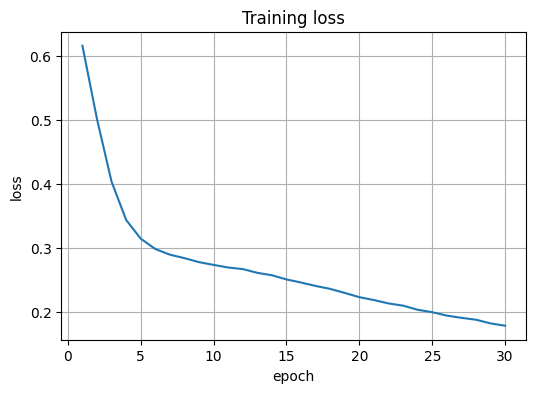

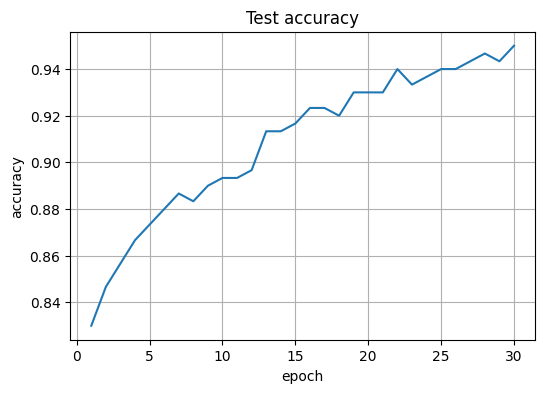

In [11]:
plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["loss"])
plt.title("Training loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["test_acc"])
plt.title("Test accuracy")
plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.grid(True); plt.show()

# 5) Оценка: порог и confusion matrix

Порог по умолчанию **0.5**, но иногда нужен другой:
- меньше FP → поднять порог
- меньше FN → снизить порог


In [12]:
test_acc, cm, probs, y_true, y_pred = evaluate(model, test_loader, device, threshold=0.5)
print("Test accuracy:", test_acc)
print("Confusion matrix:\n", cm)
print("Report:\n", classification_report(y_true, y_pred, digits=3))

for thr in [0.3, 0.5, 0.7]:
    acc_thr, _, *_ = evaluate(model, test_loader, device, threshold=thr)
    print(f"threshold={thr}: acc={acc_thr:.4f}")

Test accuracy: 0.95
Confusion matrix:
 [[143   7]
 [  8 142]]
Report:
               precision    recall  f1-score   support

           0      0.947     0.953     0.950       150
           1      0.953     0.947     0.950       150

    accuracy                          0.950       300
   macro avg      0.950     0.950     0.950       300
weighted avg      0.950     0.950     0.950       300

threshold=0.3: acc=0.9333
threshold=0.5: acc=0.9500
threshold=0.7: acc=0.9300


# 6) Сохранение и загрузка модели

Сохраняем через `state_dict()`.


In [13]:
MODEL_PATH = "/tinynet_moons_state_dict.pt"

torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

model_loaded = TinyNet(n_in=2, n_hidden=16).to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model_loaded.eval()

acc_loaded, cm_loaded, *_ = evaluate(model_loaded, test_loader, device, threshold=0.5)
print("Loaded model acc:", acc_loaded)
print("Loaded model CM:\n", cm_loaded)

Saved: /tinynet_moons_state_dict.pt
Loaded model acc: 0.95
Loaded model CM:
 [[143   7]
 [  8 142]]


---
## Итоги
- `nn.Module` + `forward` = ваша нейросеть  
- цикл: `forward → loss → zero_grad → backward → step`  
- `BCEWithLogitsLoss` работает с логитами и 0/1 float таргетом  
- сохраняем через `state_dict()`


---
# 10 заданий (задание → подсказка → код с пропусками)

Заполняйте пропуски `_____`.


## Задание 1

**Задание:** Сгенерируйте `make_moons` и сделайте train/test split (test_size=0.2, stratify=y).

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

X, y = make_moons(n_samples=_____, noise=_____, random_state=_____)
X = X.astype(_____)
y = y.astype(_____).reshape(_____, _____)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=_____, random_state=42, stratify=_____
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Задание 2

**Задание:** Сделайте TensorDataset и DataLoader (batch_size=32, shuffle=True).


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.from_numpy(_____)
y_train_t = torch.from_numpy(_____)

train_ds = TensorDataset(_____, _____)
train_loader = DataLoader(_____, batch_size=_____, shuffle=_____)

xb, yb = next(iter(train_loader))
print("xb:", xb.shape, xb.dtype)
print("yb:", yb.shape, yb.dtype)

## Задание 3

**Задание:** Допишите класс TinyNet: два Linear слоя и ReLU в forward.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TinyNetStudent(nn.Module):
    def __init__(self, n_in=2, n_hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(_____, _____)
        self.fc2 = nn.Linear(_____, _____)

    def forward(self, x):
        x = self.fc1(_____)
        x = F._____(x)
        logits = self.fc2(_____)
        return logits

m = TinyNetStudent()
print(m)

## Задание 4

**Задание:** Создайте criterion и optimizer (Adam, lr=0.01).


In [ ]:
import torch
import torch.nn as nn

model = TinyNetStudent()
criterion = nn._____
optimizer = torch.optim._____(model.parameters(), lr=_____)

print(type(criterion).__name__, type(optimizer).__name__)

## Задание 5

**Задание:** Напишите training step для одного батча: forward→loss→zero_grad→backward→step.


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNetStudent().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Xb, yb = next(iter(train_loader))
Xb = Xb.to(_____)
yb = yb.to(_____)

logits = model(_____)
loss = criterion(_____, _____)

optimizer._____()
loss._____()
optimizer._____()

print("loss:", loss.item())

## Задание 6

**Задание:** Допишите train_one_epoch: суммируйте loss по батчам и верните средний.


In [ ]:
def train_one_epoch_student(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        logits = model(_____)
        loss = criterion(_____, _____)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / _____

loss_epoch = train_one_epoch_student(model, train_loader, criterion, optimizer, device)
print("epoch loss:", loss_epoch)

## Задание 7

**Задание:** Сделайте probs = sigmoid(logits) и выведите первые 5 значений.

In [ ]:
import numpy as np
import torch

model.eval()
with torch.no_grad():
    Xb, yb = next(iter(train_loader))
    logits = model(Xb.to(device))
    probs = torch._____(logits).cpu().numpy().reshape(-1)

print("probs[:5]:", np.round(probs[:5], 3))

## Задание 8

**Задание:** Посчитайте accuracy по порогу threshold=0.5.

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

thr = _____
pred = (probs >= _____).astype(int)
y_true = yb.numpy().reshape(-1).astype(int)

print("acc:", accuracy_score(_____, _____))

## Задание 9

**Задание:** Сохраните state_dict и загрузите в новую модель, сравните logits на батче.

In [ ]:
import torch

path = "/tinynet_tmp.pt"
torch.save(model._____, path)

model2 = TinyNetStudent().to(device)
model2.load_state_dict(torch.load(_____, map_location=_____))
model2.eval()

with torch.no_grad():
    logits1 = model(Xb.to(device))
    logits2 = model2(Xb.to(device))

print("max abs diff:", (logits1 - logits2).abs().max().item())

## Задание 10

**Задание:** Обучите 15 эпох и нарисуйте график loss по эпохам.

In [ ]:
losses = []
for epoch in range(1, _____+1):
    loss = train_one_epoch_student(model, train_loader, criterion, optimizer, device)
    losses.append(loss)
    if epoch % 5 == 0:
        print(epoch, loss)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(_____)
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.show()